In [1]:
from aiFrost2 import AgentFrost2, MahjongNetFrost2
import tensorflow as tf
import numpy as np
from copy import deepcopy
from buffer import MahjongBufferFrost2
import MahjongPy as mp
from wrapper import EnvMahjong2
import scipy.io as sio
from datetime import datetime
import time

now = datetime.now()
datetime_str = now.strftime("%Y%m%d-%H%M%S")

graphs = [tf.Graph(), tf.Graph(), tf.Graph(), tf.Graph() ]

env = EnvMahjong2()

num_tile_type = env.matrix_feature_size[0]
num_each_tile = env.matrix_feature_size[1]
num_vf = env.vector_feature_size

agents = [AgentFrost2(nn=MahjongNetFrost2(graphs[i], agent_no=i, num_tile_type=num_tile_type, num_each_tile=num_each_tile, num_vf=num_vf),
                      memory=MahjongBufferFrost2(size=24, num_tile_type=num_tile_type, num_each_tile=num_each_tile, num_vf=num_vf),
                      greedy=10.0 ** np.random.uniform(-1, 1),
                      num_tile_type=num_tile_type, num_each_tile=num_each_tile, num_vf=num_vf)
          for i in range(4)]


episode_start = 1
episode_savebuffer = 128
mu_size = 40

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


##  以下的代码可以让Agent读取保存的对局buffer， 如果comment掉就可以让Agent从头开始训练

In [ ]:
# example 
# for i in range(4):
#     buffer_path =  "./buffer/Agent{}".format(i) + "-MahjongBufferFrost220190521-155324.npz"
#     agents[i].memory.load(buffer_path)

##  以下的代码可以让Agent读取保存的网络， 如果comment掉就可以让Agent从头开始训练

In [ ]:
# # example 
# for i in range(4):
#     model_path =  "../log/Agent{}".foramt(i) + "-20190501-175203-Game0/naiveAI.ckpt"
#     agents[i].nn.restore(model_path)
    

In [2]:

n_games = 1000000


process_time = 0
learn_time = 0 
select_time = 0
all_time = 0
play_time = 0
response_time = 0
copy_time = 0
done_time = 0

print("Start!")

for n in range(n_games):
    
    st_all =  time.time()
    
#     if n % 10000 == 0:
#         for i in range(4):
#             agents[i].nn.save(model_dir= "Agent{}-".format(i) + datetime_str + "-Game{}".format(n))  # save network parameters every 10000 episodes
    
#     for i in range(4):
#         if agents[i].memory.tail % episode_savebuffer == 1:
#             agents[i].memory.save("./buffer/Agent{}-".format(i) + "MahjongBufferFrost2" + datetime_str + ".npz")
    
    print("\r Game {}".format(n), end='')

    episode_dones = [[], [], [], []]
    episode_states = [[], [], [], []]
    episode_rewards = [[], [], [], []]
    episode_policies = [[], [], [], []]
    
    done = 0
#     policies = np.zeros([4,], dtype=np.int32)
    actions = np.zeros([4,], dtype=np.int32)
    rs = np.zeros([4,], dtype=np.float32)
    
    this_states = env.reset()  ## for all players
    
    next_aval_states = deepcopy(this_states)
    next_states = [[], [], [], []]
    
    step = 0
    
    while not done and step < 10000:

        who, what = env.who_do_what()
        
        st_play = time.time()
        ## make selection
        if what == "play":
            
            ######################## Draw a tile #####################
            
            next_states[who], r, done, _ = env.step_draw(playerNo=who)
            
            episode_dones[who].append(done)
            episode_states[who].append(this_states[who])
            episode_rewards[who].append(r)
            policy = np.zeros([mu_size,], dtype=np.float32)
            policy[0] += 1.
            episode_policies[who].append(policy) # only 1 available action (draw)
            
            this_states[who] = deepcopy(next_states[who])
            
            ###################### Play a tile #######################
            ###### 能和则和，能立直则立直 ############
            aval_actions = env.t.get_self_actions()
            good_actions = []
            
            if agents[who].memory.filled_size < episode_start:  # For collecting data only
                for a in range(len(aval_actions)):
                    if aval_actions[a].action == mp.Action.Riichi:
                        good_actions.append(a)

                    if aval_actions[a].action == mp.Action.Tsumo:
                        good_actions.append(a)
            #######################################
            st_process = time.time()

            next_aval_states = env.get_aval_next_states(who)  ## for a single player
            
            et_process = time.time()
            process_time += et_process - st_process     
            
            st = time.time()
            if len(good_actions) > 0:
                good_actions = np.reshape(good_actions, [-1, ])
                a_in_good_as, policy = agents[who].select([np.array(next_aval_states[0])[good_actions],
                                                           np.array(next_aval_states[1])[good_actions]])
                action = good_actions[a_in_good_as]
                tmp = np.zeros([mu_size,], dtype=np.float32)
                tmp[good_actions] = policy
                policy = deepcopy(tmp)
            else:
                action, policy = agents[who].select(next_aval_states)
                # covert policy to vector (with padding)
                tmp = np.zeros([mu_size,], dtype=np.float32)
                tmp[:np.shape(policy)[0]] = policy
                policy = deepcopy(tmp)
            et = time.time()
            select_time += et - st
            
            next_states[who], r, done, _ = env.step_play(action, playerNo=who)
            
            next_states[who] = env.get_state_(who)
            
            episode_dones[who].append(done)
            episode_states[who].append(this_states[who])
            episode_rewards[who].append(r)
            episode_policies[who].append(policy) # only 1 available action (draw)
            
            this_states[who] = deepcopy(next_states[who])
            et_play = time.time()
            play_time += et_play - st_play
#             step += 2
        
        st_response = time.time()
        if what == "response":
            policies = [np.zeros([mu_size,], dtype=np.float32) for _ in range(4)]
            for i in range(4):
                st_process = time.time()
                next_aval_states = env.get_aval_next_states(i)
                et_process = time.time()
                process_time += et_process - st_process
                ######################## 能和则和，能立直则立直 ##############
                aval_actions = env.t.get_response_actions()
                good_actions = []
                
                if agents[i].memory.filled_size < episode_start:  # For collecting data only
                    for a in range(len(aval_actions)):
                        if aval_actions[a].action == mp.Action.Ron:
                            good_actions.append(a)

                        if aval_actions[a].action == mp.Action.ChanKan:
                            good_actions.append(a)

                        if aval_actions[a].action == mp.Action.ChanAnKan:
                            good_actions.append(a)
                ##########################################################
                st = time.time()
                if len(good_actions) > 0:
                    good_actions = np.reshape(good_actions, [-1, ])
                    a_in_good_as, policies[i] = agents[i].select([np.array(next_aval_states[0])[good_actions],
                                                                  np.array(next_aval_states[1])[good_actions]])
                    actions[i] = good_actions[a_in_good_as]
                    # covert policy to vector (with padding)
                    tmp = np.zeros([mu_size,], dtype=np.float32)
                    tmp[good_actions] = policies[i]
                    policies[i] = deepcopy(tmp)
                    
                else:
                    actions[i], policies[i] = agents[i].select(next_aval_states)
                    
                    # covert policy to vector (with padding)
                    tmp = np.zeros([mu_size,], dtype=np.float32)
                    tmp[:np.shape(policies[i])[0]] = policies[i]
                    policies[i] = deepcopy(tmp)
                
                et = time.time()
                select_time += et - st
                next_states[i], rs[i], done, _ = env.step_response(actions[i], playerNo=i)
                
                ## Note: next_states is agent's prediction, but not the true one
                
            # table change after all players making actions

            for i in range(4):
                next_states[i] = env.get_state_(i)
                episode_dones[i].append(done)
                episode_states[i].append(this_states[i])
                episode_rewards[i].append(rs[i])
                episode_policies[i].append(policies[i]) # only 1 available action (draw)
        
            ## next step
            st_copy = time.time()
            for i in range(4):
                this_states[i] = deepcopy(next_states[i])
            et_copy = time.time()
            copy_time += et_copy - st_copy
            
            step += 1
        et_response = time.time()
        response_time += et_response - st_response
#         print("Game {}, step {}".format(n, step))
#         print(env.get_phase_text())
        
        if done:      
            st_done = time.time()
            final_score_change = env.get_final_score_change()
            for i in range(4):
                agents[i].statistics(i, env.t.get_result(), env.get_final_score_change(), env.t.turn,
                                     env.t.players[i].riichi, env.t.players[i].menchin)

                episode_states[i].append(env.get_state_(i))
                
                if len(episode_dones[i]) >= 1: # if not 1st turn end
                    episode_dones[i][-1] = 1
                
                #### Disable the following line if not care others
#                 episode_rewards[i][-1] = final_score_change[i]
                ##################################################
            
            if not np.max(final_score_change) == 0: ## score change
                for i in range(4):
                    agents[i].remember_episode(episode_states[i], episode_rewards[i],
                                               episode_dones[i], episode_policies[i], weight=1)
                print(' ')
                print(env.t.get_result().result_type, end='')
                print(": Totally {} steps".format(np.shape(episode_dones[0])[0]))
                
                with open("./Paipu/"+datetime.now().strftime("%Y%m%d-%H%M%S")+".txt", 'w+') as fp:
                    fp.write(mp.GameLogToString(env.t.game_log).decode('GBK'))
            else:
                if np.random.rand() < 0.025: ## no score change
                    for i in range(4):
                        agents[i].remember_episode(episode_states[i], episode_rewards[i],
                                                   episode_dones[i], episode_policies[i], weight=1)
                    print(' ')
                    print(env.t.get_result().result_type, end='')
                    print(": Totally {} steps".format(np.shape(episode_dones[0])[0]))
            
            st = time.time()
            for n_train in range(5):
                for i in range(4):
                    agents[i].learn(env.symmetric_matrix_features, episode_start=episode_start, logging=False)
            et = time.time()
            learn_time += et - st
            
            et_done = time.time()
            done_time += et_done - st_done
            
            et_all = time.time()
            all_time += et_all - st_all

data = {"rons": env.final_score_changes}
sio.savemat("./final_score_changes" + datetime_str + ".mat", data)


Start!
 Game 15

TypeError: append_episode() missing 1 required positional argument: 'mu'

In [ ]:
env.t.get_response_actions()[0].action

In [ ]:
print(all_time)
print(select_time)
print(learn_time)
print(play_time)
print(response_time)
print(process_time)
print(done_time)
print(copy_time)

In [ ]:
## Check tiles
for p in range(4):
    hand = env.t.players[p].hand
    print('player {}'.format(p))
    for k in range(len(hand)):
        print(hand[k].tile)
for p in range(4):
    fulus = env.t.players[p].fulus
    print('player {}'.format(p))
    for k in range(len(fulus)):
        print(fulus[k].to_string())  

In [ ]:
env.t.DORA[0].tile

In [ ]:
this_states[0][0][:,28]

In [ ]:
import matplotlib.pyplot as plt
for i in range(1):
    plt.pcolor(env.get_state_(i)[0][:,:5])
    plt.colorbar()
    plt.show()
    


In [ ]:
for i in range(1):
    plt.pcolor(env.get_next_state(0, i)[0])
    print(env.t.get_response_actions()[0].action)
    plt.colorbar()
    plt.show()

## Predict score (value function)

In [8]:
t.get_phase()

0

In [1]:
import MahjongPy as mp
t = mp.Table()
t.game_init()

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
S = t.get_next_aval_states_matrix_features_frost2(0)[3]


In [ ]:
mp.GameLogToString(env.t.game_log).decode('GBK')

In [ ]:
env.

In [ ]:
np.argmin([-1, -1, 0, 0])

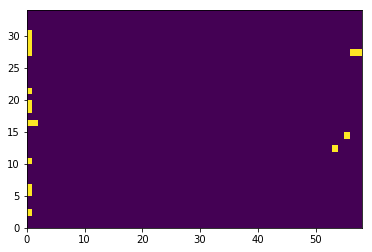

In [12]:
plt.pcolor(np.reshape(np.array(S), [34, 58]))
plt.show()

In [2]:
import sparse as sps
import numpy as np

In [12]:
S = [sps.COO(shape=(200, 20, 34, 58)) for _ in range(1024)]

TypeError: __init__() missing 1 required positional argument: 'coords'

In [11]:
S[1].todense()

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    